<h2 align="center" style="color:blue">Codebasics ML Course: Regression Project Exercise Solution</h2>

In [38]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

<h2 align="center" style="color:blue">Data Loading</h2>

In [41]:
df = pd.read_excel("premiums_with_life_style.xlsx")
df.head(3)

,Age,Gender,Region,Marital_status,Physical_Activity,Stress_Level,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,56,Female,Southeast,Unmarried,Medium,Medium,2,Normal,No Smoking,Self-Employed,25L - 40L,37,High blood pressure,Gold,27944
1,38,Female,Northeast,Married,Low,High,5,Overweight,Occasional,Freelancer,10L - 25L,10,No Disease,Silver,21108
2,18,Female,Southwest,Unmarried,Medium,High,0,Normal,No Smoking,Freelancer,<10L,9,No Disease,Bronze,8459


In [42]:
df.shape

(10000, 15)

In [43]:
df.columns = df.columns.str.replace(" ","_").str.lower()
df.head(3)

,age,gender,region,marital_status,physical_activity,stress_level,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,56,Female,Southeast,Unmarried,Medium,Medium,2,Normal,No Smoking,Self-Employed,25L - 40L,37,High blood pressure,Gold,27944
1,38,Female,Northeast,Married,Low,High,5,Overweight,Occasional,Freelancer,10L - 25L,10,No Disease,Silver,21108
2,18,Female,Southwest,Unmarried,Medium,High,0,Normal,No Smoking,Freelancer,<10L,9,No Disease,Bronze,8459


<h2 align="center" style="color:blue">Exploratory Data Analysis & Data Cleaning</h2>

### Handle Missing Values

In [46]:
df.isna().sum()

age                       0
gender                    0
region                    0
marital_status            0
physical_activity         0
stress_level              0
number_of_dependants      0
bmi_category              0
smoking_status            9
employment_status         7
income_level             18
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

In [47]:
df.dropna(inplace=True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
physical_activity        0
stress_level             0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

### Handle Duplicates

In [49]:
df.duplicated().sum()

0

In [50]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [51]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,9973.000000,9973.000000,9973.000000,9973.000000
mean,41.319362,3.195628,23.382232,19503.816705
std,58.044687,21.679565,32.334811,8898.079736
min,18.000000,0.000000,1.000000,3582.000000
25%,24.000000,0.000000,6.000000,11774.000000
50%,37.000000,2.000000,16.000000,19314.000000
75%,50.000000,3.000000,31.000000,26500.000000
max,1178.000000,456.000000,960.000000,45854.000000


## 1. Numeric Columns

### Univariate Analysis: Numeric Columns

#### Box plots for numeric columns

In [63]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
numeric_columns  

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

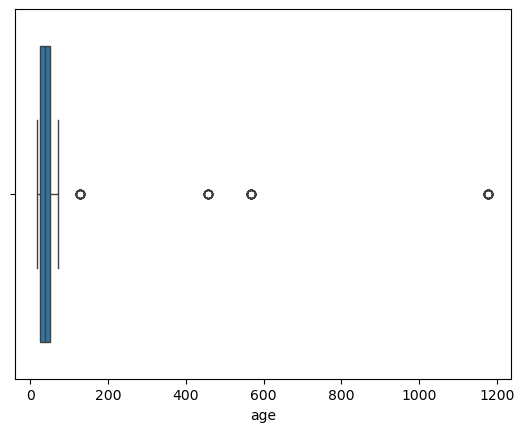

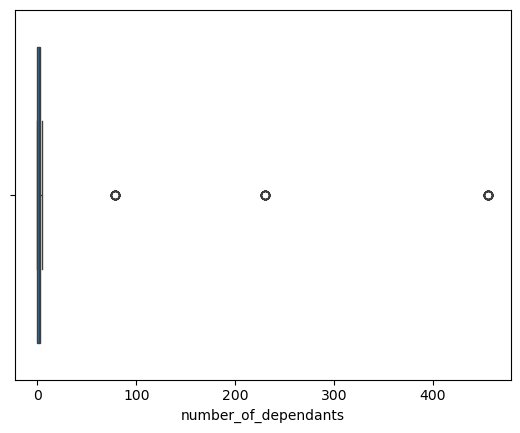

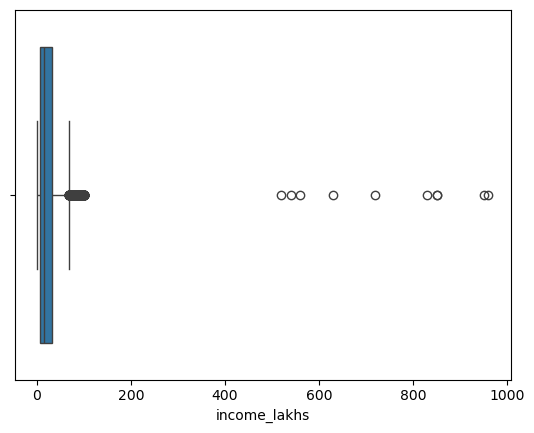

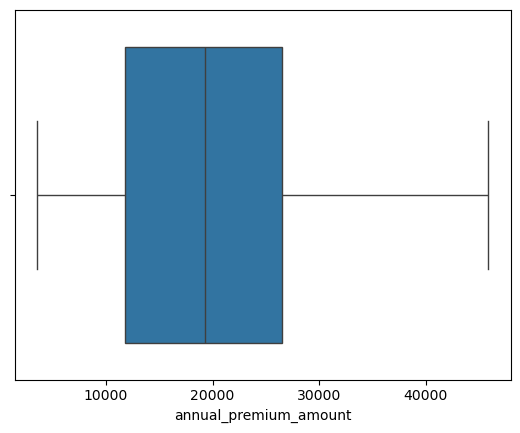

In [65]:
for col in numeric_columns:
    sns.boxplot(x=df[col])
    plt.show()

### Outlier Treatment: Age Column

In [68]:
df[df['age']>100]['age'].unique()


array([ 128, 1178,  567,  456], dtype=int64)

In [70]:
df1 = df[df.age<=100]
df1.age.describe()

count    9915.000000
mean       37.743621
std        13.975462
min        18.000000
25%        24.000000
50%        37.000000
75%        50.000000
max        72.000000
Name: age, dtype: float64

### Outlier Treatment: Income Column

In [73]:
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25, 0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

lower, upper = get_iqr_bounds(df1['income_lakhs'])
lower, upper

(-31.5, 68.5)

In [75]:
df1[df1.income_lakhs>upper].shape

(697, 15)

There are many legitimate records that we will get rid of if we use IQR bounds method. Hence after discussion with business we decided to use a simple quantile bound 

In [78]:
quantile_thresold = df1.income_lakhs.quantile(0.999)
quantile_thresold

136.12000000048283

In [80]:
df1[df1.income_lakhs>quantile_thresold].shape

(10, 15)

In [82]:
df2 = df1[df1.income_lakhs<=quantile_thresold].copy()
df2.shape

(9905, 15)

### Outlier Treatment: Dependants

In [85]:
df2.number_of_dependants.describe()

count    9905.000000
mean        3.205553
std        21.753158
min         0.000000
25%         0.000000
50%         2.000000
75%         3.000000
max       456.000000
Name: number_of_dependants, dtype: float64

<Axes: xlabel='number_of_dependants', ylabel='Count'>

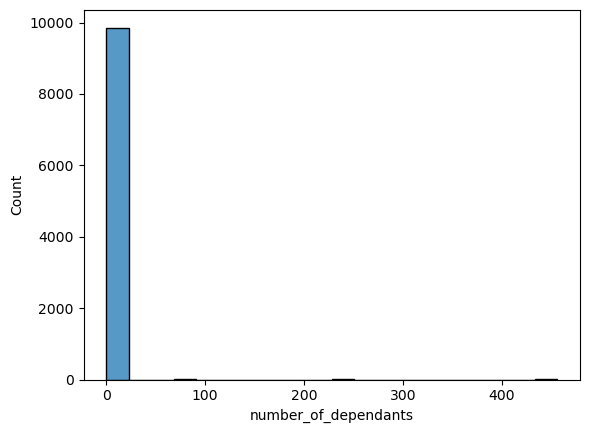

In [87]:
sns.histplot(df2.number_of_dependants,bins=20)

In [89]:
dependant_thresold = df2.number_of_dependants.quantile(0.99)
dependant_thresold

5.0

In [91]:
df3 = df2[df2.number_of_dependants<=dependant_thresold].copy()
df3.number_of_dependants.describe()

count    9858.000000
mean        1.919963
std         1.503027
min         0.000000
25%         0.000000
50%         2.000000
75%         3.000000
max         5.000000
Name: number_of_dependants, dtype: float64

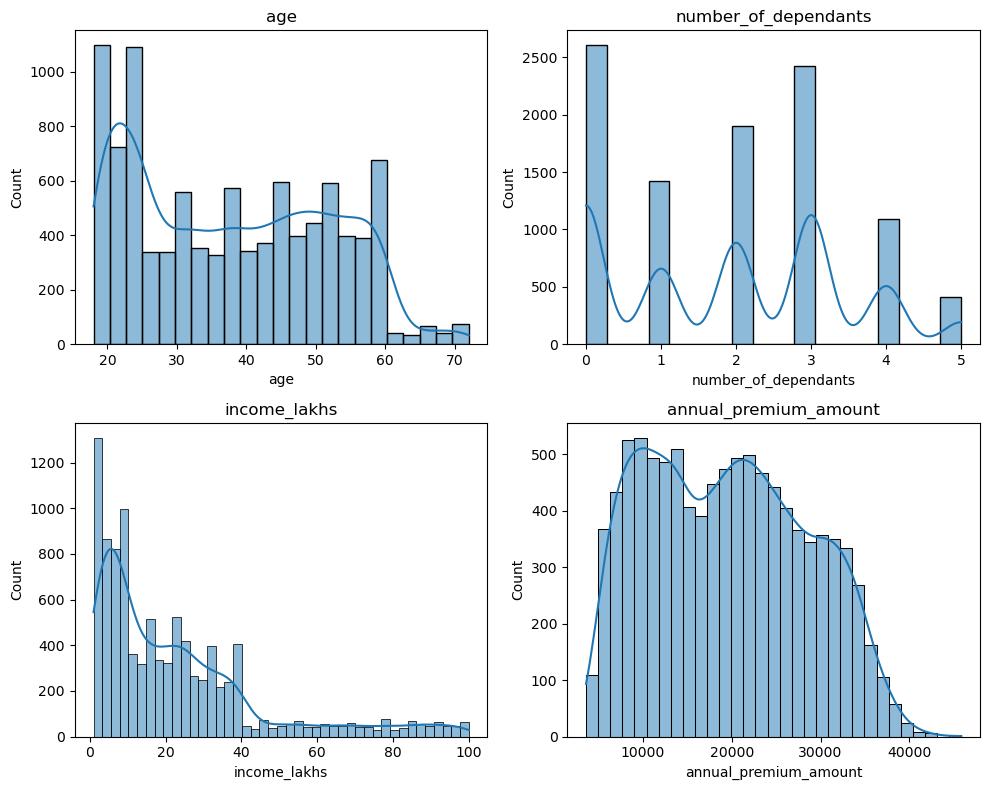

In [93]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))  # Adjust the size as necessary

for i, column in enumerate(numeric_columns):
    ax = axs[i//2, i%2]  # Determines the position of the subplot in the grid
    sns.histplot(df3[column], kde=True, ax=ax)
    ax.set_title(column)

plt.tight_layout()
plt.show()

### Bivariate Analysis: Numeric Columns

In [96]:
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

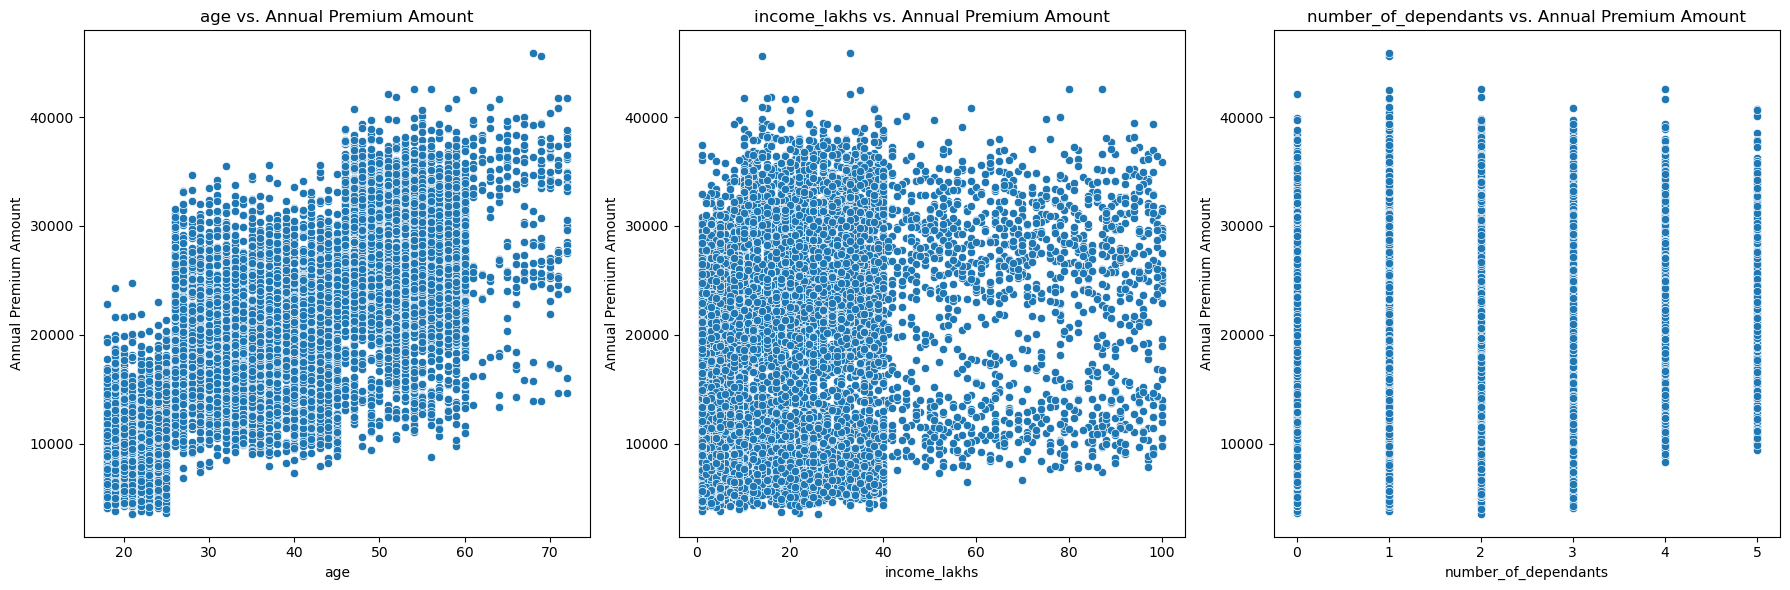

In [98]:
numeric_features = ['age', 'income_lakhs', 'number_of_dependants']

fig, axes = plt.subplots(1, len(numeric_features), figsize=(18, 6))  # Adjust figure size as necessary

for ax, column in zip(axes, numeric_features):
    sns.scatterplot(x=df3[column], y=df3['annual_premium_amount'], ax=ax)
    ax.set_title(f'{column} vs. Annual Premium Amount')
    ax.set_xlabel(column)
    ax.set_ylabel('Annual Premium Amount')

plt.tight_layout()  # Adjust layout
plt.show()

## 2. Categorical Columns

In [101]:
df3.head(2)

,age,gender,region,marital_status,physical_activity,stress_level,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,56,Female,Southeast,Unmarried,Medium,Medium,2,Normal,No Smoking,Self-Employed,25L - 40L,37,High blood pressure,Gold,27944
1,38,Female,Northeast,Married,Low,High,5,Overweight,Occasional,Freelancer,10L - 25L,10,No Disease,Silver,21108


In [103]:
categorical_cols = ['gender', 'region', 'marital_status', 'physical_activity', 'stress_level', 'bmi_category', 'smoking_status', 'employment_status', 'income_level', 'medical_history', 'insurance_plan']
for col in categorical_cols:
    print(col, ":", df3[col].unique())

gender : ['Female' 'Male']
region : ['Southeast' 'Northeast' 'Southwest' 'Northwest']
marital_status : ['Unmarried' 'Married']
physical_activity : ['Medium' 'Low' 'High']
stress_level : ['Medium' 'High' 'Low']
bmi_category : ['Normal' 'Overweight' 'Obesity' 'Underweight']
smoking_status : ['No Smoking' 'Occasional' 'Regular']
employment_status : ['Self-Employed' 'Freelancer' 'Salaried']
income_level : ['25L - 40L' '10L - 25L' '<10L' '> 40L']
medical_history : ['High blood pressure' 'No Disease' 'Thyroid'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid' 'Diabetes'
 'Heart disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease']
insurance_plan : ['Gold' 'Silver' 'Bronze']


### Univariate Analysis

In [106]:
df3.head(2)

,age,gender,region,marital_status,physical_activity,stress_level,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,56,Female,Southeast,Unmarried,Medium,Medium,2,Normal,No Smoking,Self-Employed,25L - 40L,37,High blood pressure,Gold,27944
1,38,Female,Northeast,Married,Low,High,5,Overweight,Occasional,Freelancer,10L - 25L,10,No Disease,Silver,21108


In [108]:
pct_count = df3['gender'].value_counts(normalize=True)*100
pct_count

gender
Female    59.870156
Male      40.129844
Name: proportion, dtype: float64

<Axes: xlabel='gender'>

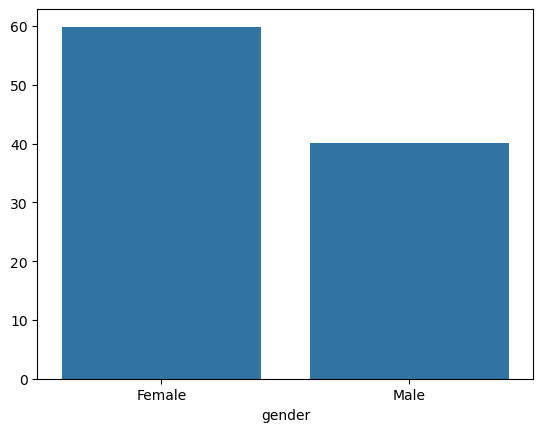

In [110]:
sns.barplot(x=pct_count.index, y=pct_count.values)

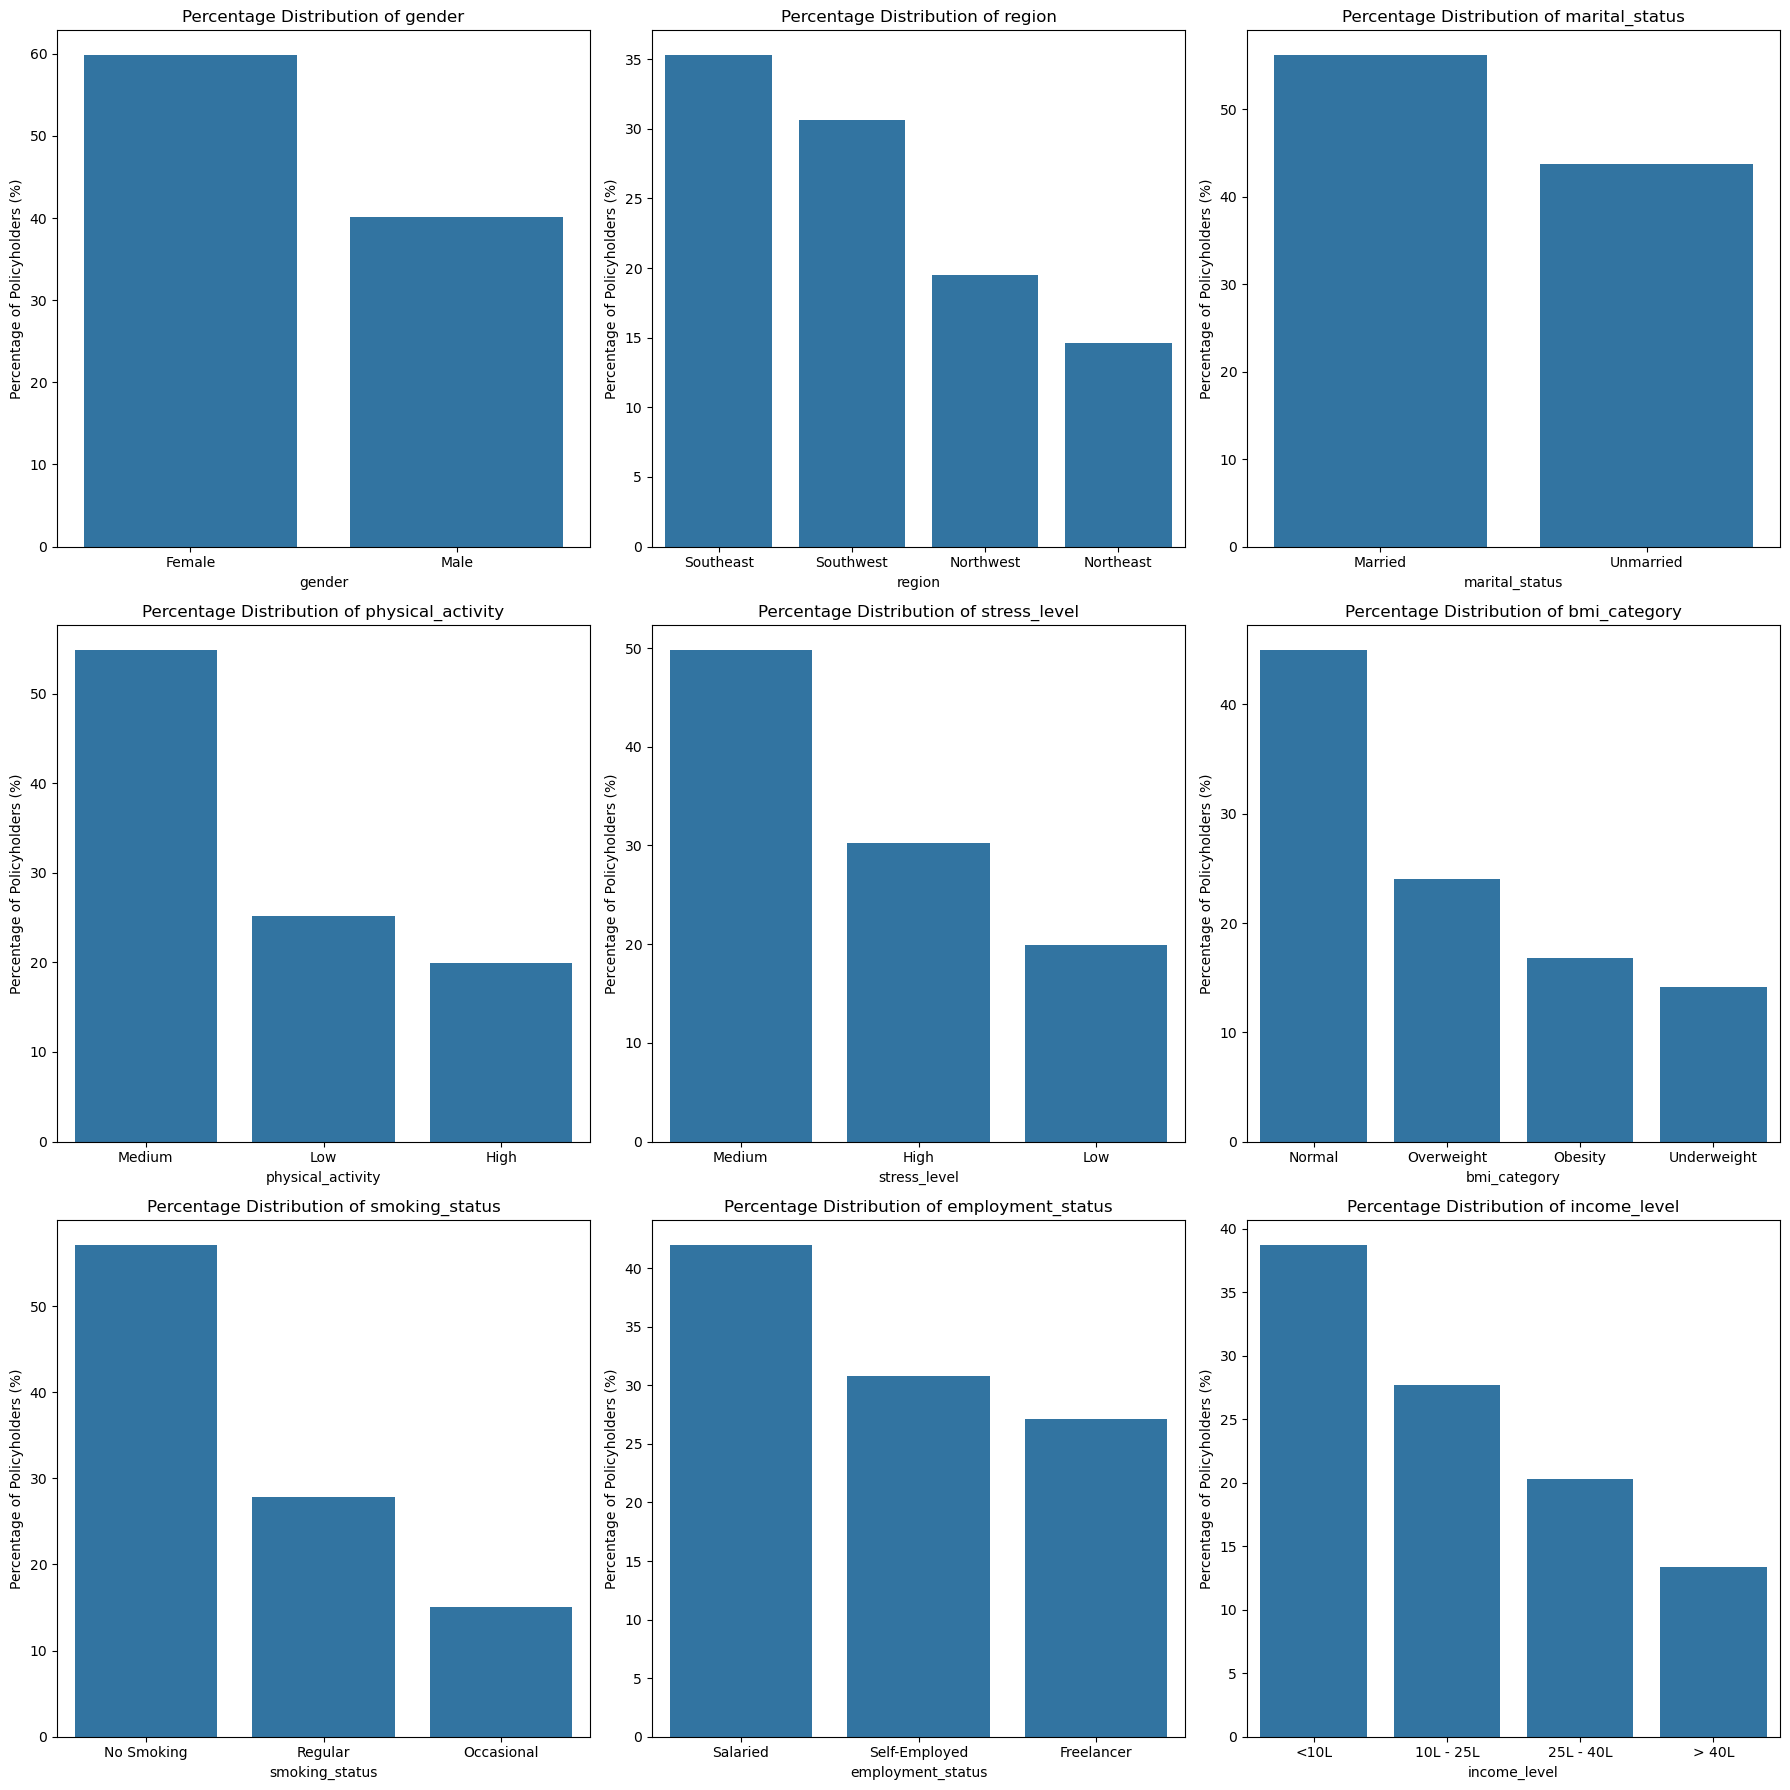

In [112]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))  # Adjust figure size as necessary
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for ax, column in zip(axes, categorical_cols):
    # Calculate the percentage distribution of each category
    category_counts = df3[column].value_counts(normalize=True) * 100  # normalize=True gives the relative frequencies
    
    # Plotting the distribution using barplot
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax)
    ax.set_title(f'Percentage Distribution of {column}')
    ax.set_ylabel('Percentage of Policyholders (%)')
    ax.set_xlabel(column)  # Set xlabel to the column name for clarity

plt.tight_layout()  # Adjusts plot parameters for better fit in the figure window
plt.show()

### Bivariate Analysis

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L          822   909     998
25L - 40L          533   733     733
<10L              2266   184    1366
> 40L               55   788     471


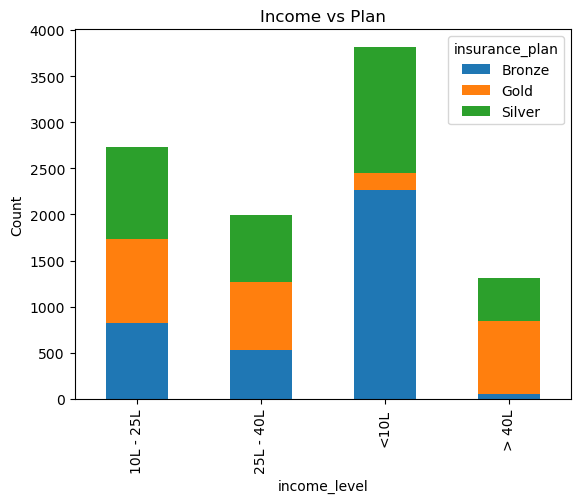

In [115]:
# Cross-tabulation of gender and smoking status
crosstab = pd.crosstab(df3['income_level'], df3['insurance_plan'])
print(crosstab)

# Plotting the crosstab
crosstab.plot(kind='bar', stacked=True)
plt.title('Income vs Plan')
plt.ylabel('Count')
plt.show()

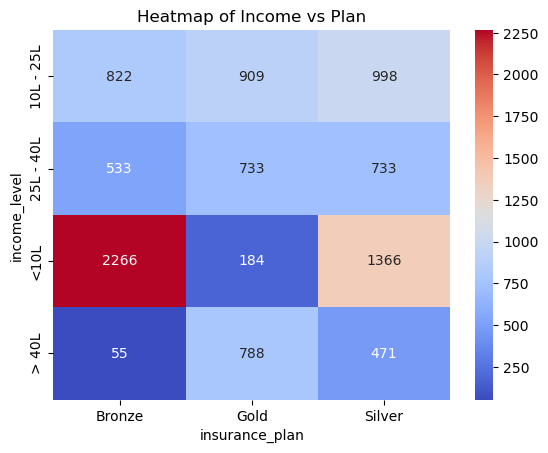

In [117]:
sns.heatmap(crosstab, annot=True, cmap='coolwarm',fmt="d")
plt.title('Heatmap of Income vs Plan')
plt.show()

<h2 align="center" style="color:blue">Feature Engineering</h2>

In [120]:
df3.head(2)

,age,gender,region,marital_status,physical_activity,stress_level,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,56,Female,Southeast,Unmarried,Medium,Medium,2,Normal,No Smoking,Self-Employed,25L - 40L,37,High blood pressure,Gold,27944
1,38,Female,Northeast,Married,Low,High,5,Overweight,Occasional,Freelancer,10L - 25L,10,No Disease,Silver,21108


### Calculate Risk Score

In [127]:
# Define the risk scores for each condition
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure":6,
    "thyroid": 5,
    "no disease": 0,
    "none":0
}

df3[['disease1', 'disease2']] = df3['medical_history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())
# df3['disease1'].fillna('none', inplace=True)
# df3['disease2'].fillna('none', inplace=True)
df3.fillna({'disease1' : 'none'},inplace = True)
df3.fillna({'disease2' : 'none'},inplace = True)


df3['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
    df3['total_risk_score'] += df3[disease].map(risk_scores)

# Normalize the risk score to a range of 0 to 1
max_score = df3['total_risk_score'].max()
min_score = df3['total_risk_score'].min()
df3['normalized_risk_score'] = (df3['total_risk_score'] - min_score) / (max_score - min_score)
df3.head(2)

,age,gender,region,marital_status,physical_activity,stress_level,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,56,Female,Southeast,Unmarried,Medium,Medium,2,Normal,No Smoking,Self-Employed,25L - 40L,37,High blood pressure,Gold,27944,high blood pressure,none,6,0.428571
1,38,Female,Northeast,Married,Low,High,5,Overweight,Occasional,Freelancer,10L - 25L,10,No Disease,Silver,21108,no disease,none,0,0.000000


### Calculate Life Style Risk Score

In [129]:
def calculate_life_style_risk(row):
    physical_activity_risk_score = {
        "High": 0,
        "Medium": 1,
        "Low": 4
    }
    stress_risk_score = {
        "High": 4,
        "Medium": 1,
        "Low": 0
    }
    life_style_risk = physical_activity_risk_score[row['physical_activity']] + stress_risk_score[row['stress_level']]
    return life_style_risk

df3['lifestyle_risk_score'] = df3.apply(calculate_life_style_risk, axis=1)

<Axes: xlabel='lifestyle_risk_score', ylabel='Count'>

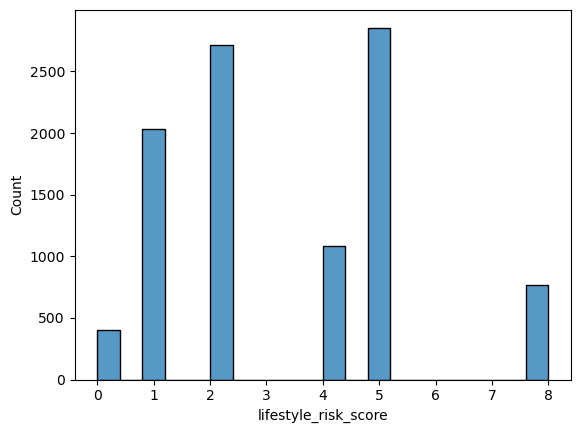

In [131]:
sns.histplot(df3.lifestyle_risk_score, bins=20)

### Encode Text Columns

In [134]:
df3.head()

,age,gender,region,marital_status,physical_activity,stress_level,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score,lifestyle_risk_score
0,56,Female,Southeast,Unmarried,Medium,Medium,2,Normal,No Smoking,Self-Employed,25L - 40L,37,High blood pressure,Gold,27944,high blood pressure,none,6,0.428571,2
1,38,Female,Northeast,Married,Low,High,5,Overweight,Occasional,Freelancer,10L - 25L,10,No Disease,Silver,21108,no disease,none,0,0.000000,8
2,18,Female,Southwest,Unmarried,Medium,High,0,Normal,No Smoking,Freelancer,<10L,9,No Disease,Bronze,8459,no disease,none,0,0.000000,5
3,55,Male,Northeast,Married,High,Medium,3,Overweight,Occasional,Salaried,<10L,9,Thyroid,Silver,21685,thyroid,none,5,0.357143,1
4,22,Male,Southeast,Unmarried,Medium,High,2,Normal,Regular,Self-Employed,10L - 25L,13,High blood pressure & Heart disease,Bronze,15984,high blood pressure,heart disease,14,1.000000,5


In [136]:
df3['insurance_plan'] = df3['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})

In [138]:
df3.head(2)

,age,gender,region,marital_status,physical_activity,stress_level,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score,lifestyle_risk_score
0,56,Female,Southeast,Unmarried,Medium,Medium,2,Normal,No Smoking,Self-Employed,25L - 40L,37,High blood pressure,3,27944,high blood pressure,none,6,0.428571,2
1,38,Female,Northeast,Married,Low,High,5,Overweight,Occasional,Freelancer,10L - 25L,10,No Disease,2,21108,no disease,none,0,0.000000,8


In [140]:
df3.income_level.unique()

array(['25L - 40L', '10L - 25L', '<10L', '> 40L'], dtype=object)

In [142]:
df3['income_level'] = df3['income_level'].map({'<10L':1, '10L - 25L': 2, '25L - 40L':3, '> 40L':4})

In [144]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df4 = pd.get_dummies(df3, columns=nominal_cols, drop_first=True, dtype=int)
df4.head(3)

,age,physical_activity,stress_level,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,56,Medium,Medium,2,3,37,High blood pressure,3,27944,high blood pressure,...,1,0,1,0,0,0,0,0,0,1
1,38,Low,High,5,2,10,No Disease,2,21108,no disease,...,0,0,0,0,1,0,1,0,0,0
2,18,Medium,High,0,1,9,No Disease,1,8459,no disease,...,0,1,1,0,0,0,0,0,0,0


In [146]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9858 entries, 0 to 9999
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              9858 non-null   int64  
 1   physical_activity                9858 non-null   object 
 2   stress_level                     9858 non-null   object 
 3   number_of_dependants             9858 non-null   int64  
 4   income_level                     9858 non-null   int64  
 5   income_lakhs                     9858 non-null   int64  
 6   medical_history                  9858 non-null   object 
 7   insurance_plan                   9858 non-null   int64  
 8   annual_premium_amount            9858 non-null   int64  
 9   disease1                         9858 non-null   object 
 10  disease2                         9858 non-null   object 
 11  total_risk_score                 9858 non-null   int64  
 12  normalized_risk_score    

### Feature Selection

In [149]:
df5 = df4.drop(['medical_history','disease1', 'disease2', 'total_risk_score','physical_activity','stress_level'], axis=1)
df5.head(3)                

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,lifestyle_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,56,2,3,37,3,27944,0.428571,2,0,0,1,0,1,0,0,0,0,0,0,1
1,38,5,2,10,2,21108,0.000000,8,0,0,0,0,0,0,1,0,1,0,0,0
2,18,0,1,9,1,8459,0.000000,5,0,0,0,1,1,0,0,0,0,0,0,0


### Calculate VIF for Multicolinearity

In [152]:
df5.columns

Index(['age', 'number_of_dependants', 'income_level', 'income_lakhs',
       'insurance_plan', 'annual_premium_amount', 'normalized_risk_score',
       'lifestyle_risk_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

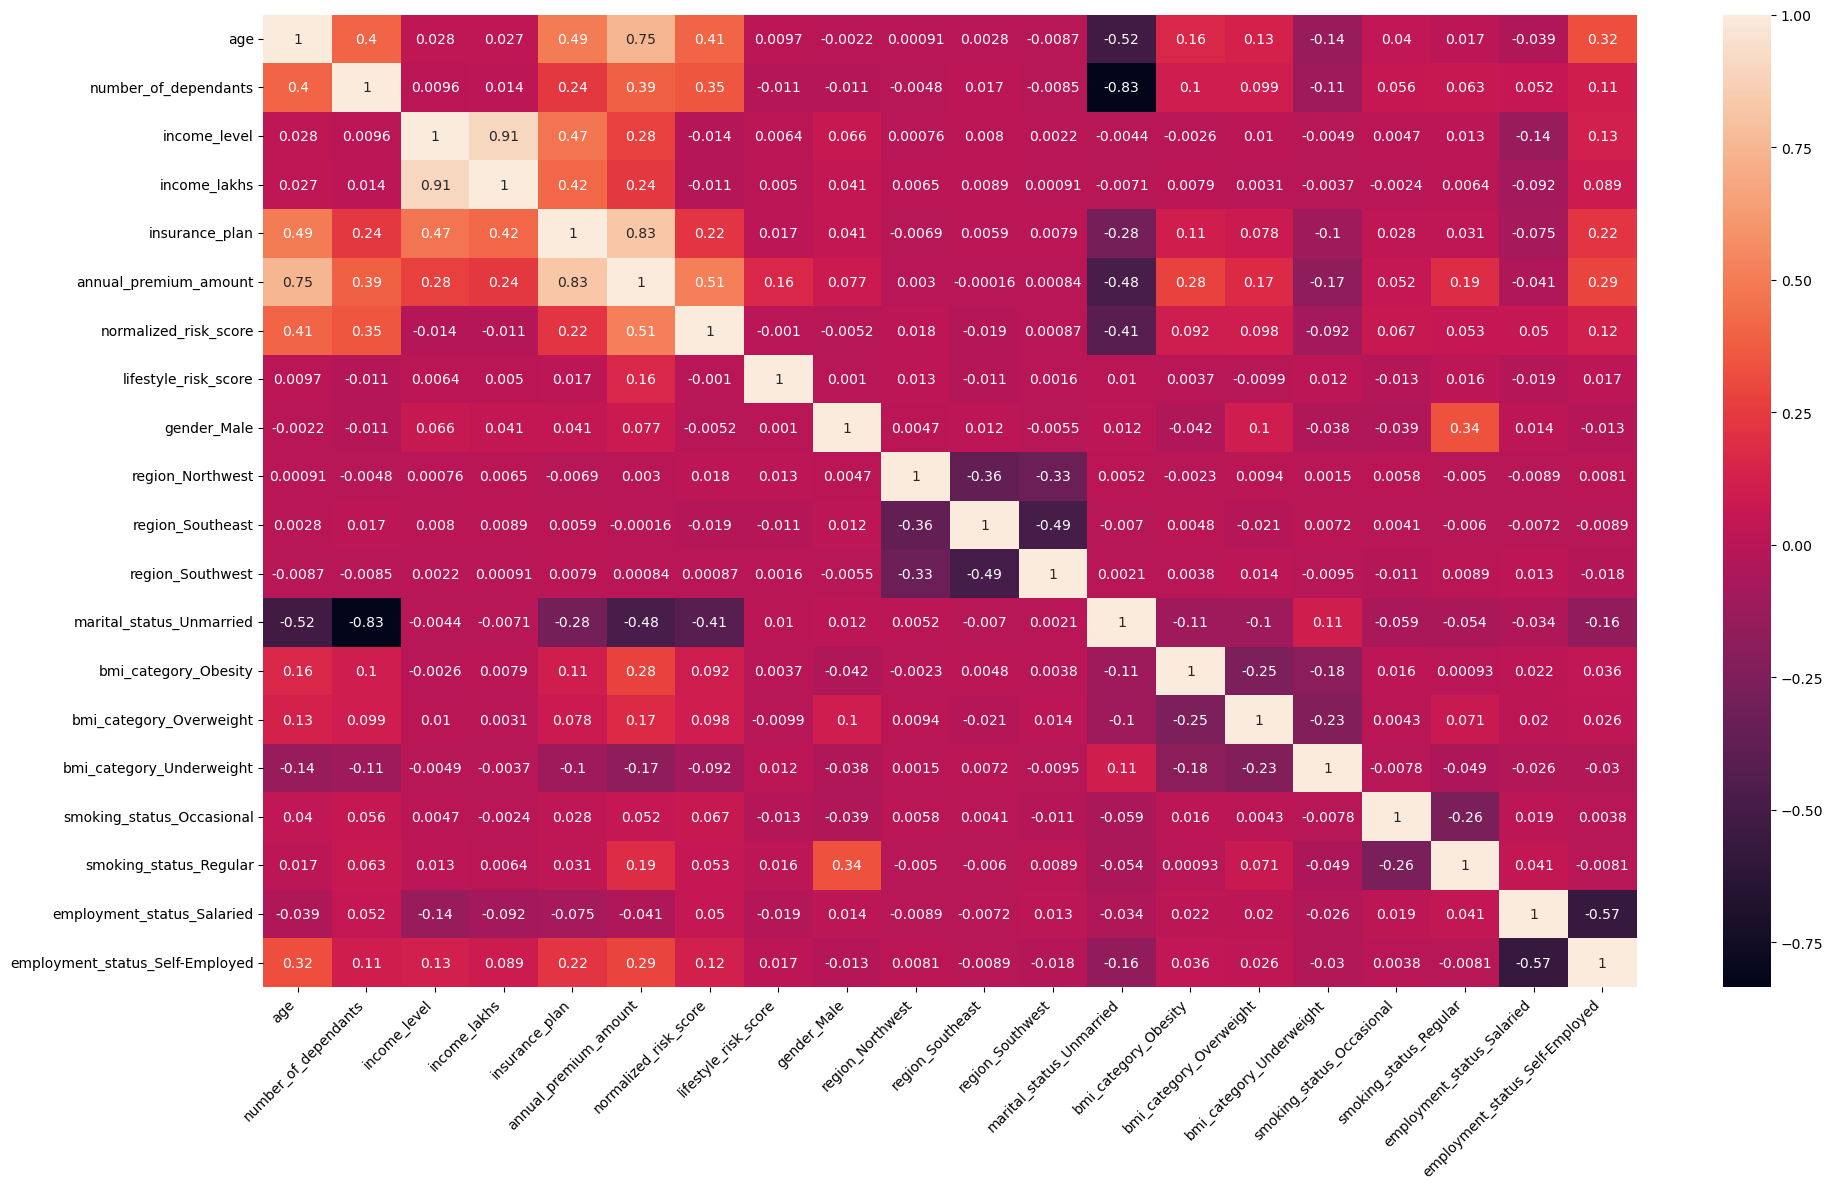

In [154]:
cm = df5.corr()

plt.figure(figsize=(20,12))
sns.heatmap(cm, annot=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [156]:
X = df5.drop('annual_premium_amount', axis='columns')
y = df5['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler

cols_to_scale = ['age','number_of_dependants', 'income_level',  'income_lakhs', 'insurance_plan', 'lifestyle_risk_score']
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,lifestyle_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000
mean,0.366014,0.383993,0.360756,0.219027,0.446135,0.326537,0.408349,0.401298,0.194664,0.353013,0.306452,0.437716,0.167985,0.240414,0.141712,0.150030,0.278657,0.420065,0.308176
std,0.258820,0.300605,0.352198,0.226801,0.395765,0.279083,0.268302,0.490186,0.395962,0.477931,0.461043,0.496131,0.373872,0.427356,0.348773,0.357119,0.448361,0.493594,0.461763
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.111111,0.000000,0.000000,0.050505,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.351852,0.400000,0.333333,0.151515,0.500000,0.428571,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.592593,0.600000,0.666667,0.303030,1.000000,0.428571,0.625000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [158]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [160]:
calculate_vif(X)

,Column,VIF
0,age,5.541063
1,number_of_dependants,5.320401
2,income_level,12.548788
3,income_lakhs,10.947288
4,insurance_plan,4.147071
5,normalized_risk_score,3.001706
6,lifestyle_risk_score,3.110913
7,gender_Male,1.910118
8,region_Northwest,2.082989
9,region_Southeast,2.952809


In [162]:
calculate_vif(X.drop('income_level', axis="columns"))

,Column,VIF
0,age,5.488217
1,number_of_dependants,5.306542
2,income_lakhs,2.450579
3,insurance_plan,3.875312
4,normalized_risk_score,3.001684
5,lifestyle_risk_score,3.110034
6,gender_Male,1.901611
7,region_Northwest,2.082813
8,region_Southeast,2.951877
9,region_Southwest,2.678296


In [164]:
# we will drop income_lakhs due to high VIF value
X_reduced = X.drop('income_level', axis="columns")

<h2 align="center" style="color:blue">Model Training</h2>

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.30, random_state=10)

# shape of the X_train, X_test, y_train, y_test features
print("x train: ",X_train.shape)
print("x test: ",X_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (6900, 18)
x test:  (2958, 18)
y train:  (6900,)
y test:  (2958,)


### Linear Regression Model

In [169]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score = model_lr.score(X_train, y_train)
train_score, test_score

(0.9586426437876246, 0.9572516785678009)

In [170]:
y_pred = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Linear Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

Linear Regression ==> MSE:  3320807.9034878286 RMSE:  1822.3083996645103


In [171]:
X_test.shape

(2958, 18)

In [172]:
np.set_printoptions(suppress=True, precision=6)
model_lr.coef_

array([10675.837861,  -671.110352,  -708.275605, 13311.846824,
        6521.438689,  4724.386632,    11.961022,    77.061876,
          88.325309,    -9.701258,  -820.804958,  4166.09646 ,
        2119.215673,   413.650051,  1159.508746,  3116.482686,
          17.894652,   382.995584])

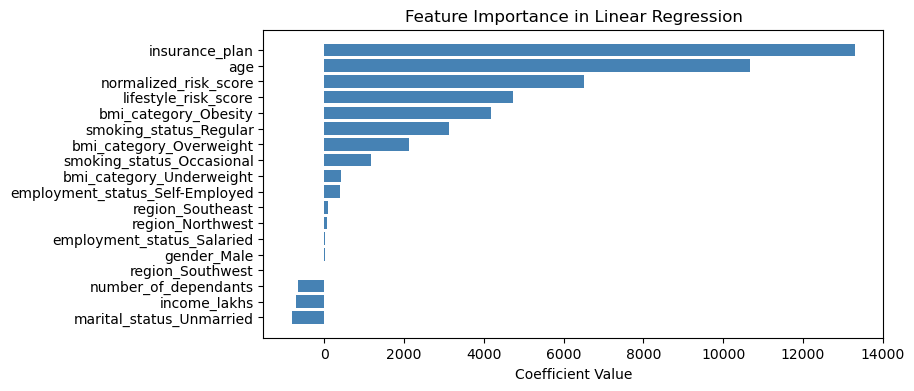

In [173]:
feature_importance = model_lr.coef_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

### XGBoost 

In [ ]:
pip install xgboost

In [214]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor(n_estimators=20, max_depth=3)
model_xgb.fit(X_train, y_train)
model_xgb.score(X_test, y_test)

0.9886000156402588

In [216]:
y_pred = model_xgb.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("XGBoost Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

XGBoost Regression ==> MSE:  885582.3233142267 RMSE:  941.0538365652768


In [218]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
random_search.best_score_

0.9925432205200195

In [219]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}

In [220]:
best_model = random_search.best_estimator_

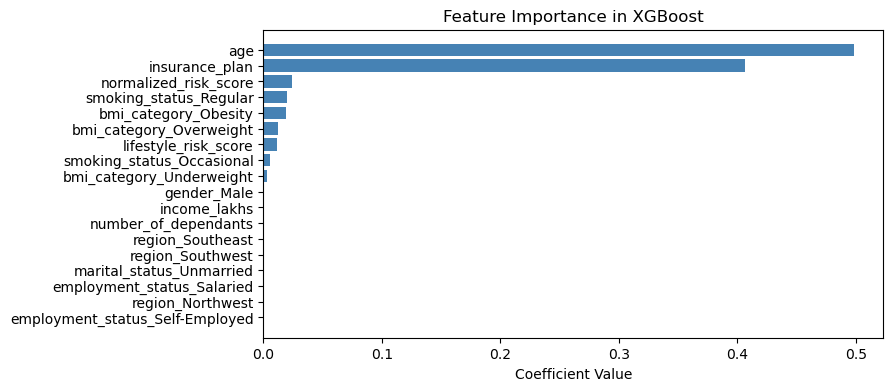

In [221]:
feature_importance = best_model.feature_importances_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBoost')
plt.show()

In [222]:
y_pred = best_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct = (residuals / y_test) * 100

results_df = pd.DataFrame({
    'actual': y_test, 
    'predicted': y_pred, 
    'diff': residuals, 
    'diff_pct': residuals_pct
})
results_df.head()

,actual,predicted,diff,diff_pct
3021,13354,12226.655273,-1127.344727,-8.442000
6049,10701,11696.637695,995.637695,9.304156
6146,15146,16290.446289,1144.446289,7.556096
6418,8743,9265.954102,522.954102,5.981403
1537,27887,26731.242188,-1155.757812,-4.144432


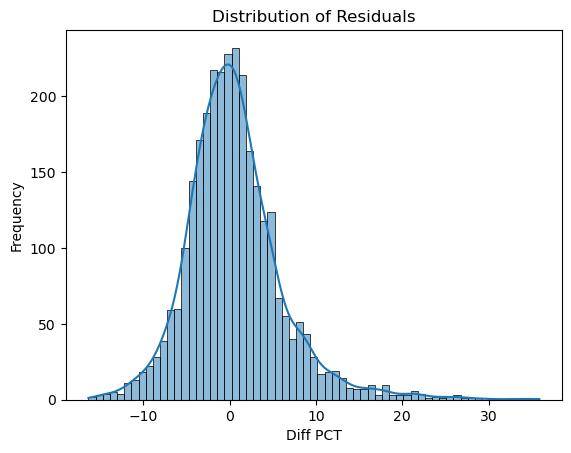

In [223]:
sns.histplot(results_df['diff_pct'], kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Diff PCT')
plt.ylabel('Frequency')
plt.show()

In [224]:
X_test.shape

(2958, 18)

In [225]:
extreme_error_threshold = 10  # You can adjust this threshold based on your domain knowledge or requirements
extreme_results_df = results_df[np.abs(results_df['diff_pct']) > extreme_error_threshold]
extreme_results_df.head()

,actual,predicted,diff,diff_pct
7800,9632,8650.812500,-981.187500,-10.186747
9814,6655,5948.608398,-706.391602,-10.614449
9970,6484,7225.738770,741.738770,11.439525
6882,14831,12876.333008,-1954.666992,-13.179603
5015,9981,11260.881836,1279.881836,12.823182


In [226]:
extreme_results_df.shape

(204, 4)

In [227]:
extreme_errors_pct = extreme_results_df.shape[0]*100/X_test.shape[0]
extreme_errors_pct

6.896551724137931

There is about 6.9% extreme errors